# Задача
2. На основе полученных прогнозов разработать механизм для определения аномальных дней, когда фактический GMV (или количество заказов) значительно отклоняется от прогнозного значения. 
  Что нужно сделать:
   * Расчет остатков (разницу между фактическими и прогнозными значениями).
   * Определение порога аномалии.  Аномальными будут считаться дни, когда абсолютное значение остатка |факт - прогноз| превышает `threshold = K * std_residuals`.
     * `std_residuals` – это стандартное отклонение остатков (разниц между фактическими и прогнозными значениями), рассчитанное на обучающей или валидационной выборке (после построения модели).
     * `K` – это коэффициент, который определяет чувствительность метода: более высокое значение K означает, что только более крупные отклонения будут считаться аномалиями (менее чувствительная система).
     Более низкое значение K сделает систему более чувствительной к меньшим отклонениям (больше потенциальных аномалий, но и выше риск ложных срабатываний).
     Необходимо поэкспериментировать с различными значениями K и обосновать свой выбор.
   * Детекция аномалий на тестовых данных. Для детекции аномалий используются фактические значения из тестовой выборки (той части исходного набора данных daily_metrics_dataset.csv, которая была отложена для оценки качества моделей прогнозирования в подзадаче 1.1) и прогнозы, полученные моделью для тех же дат. 
   * Визуализация и анализ аномалий (Выбор визуального компеонента остаётся на усмотрение соискателя).


In [42]:
import pandas as pd
import numpy as np

In [43]:
test = pd.read_csv('../Task_1.1/test.csv')#.drop(columns=['Unnamed: 0'])
test.index=test['Unnamed: 0'].values
test.drop(columns=['Unnamed: 0'],inplace=True)
test.head()

,gmv,sessions,marketing_spend,is_promo_active,holiday_proximity,gmv_lag_1,sessions_lag_1,marketing_spend_lag_1,gmv_lag_2,sessions_lag_2,...,gmv_h5,gmv_h6,gmv_h7,gmv_h1_pred,gmv_h2_pred,gmv_h3_pred,gmv_h4_pred,gmv_h5_pred,gmv_h6_pred,gmv_h7_pred
723,645437,104083,39114,0,0.3,738853.0,130017.0,41696.0,855540.0,149745.0,...,857564.0,732198.0,599808.0,744288.545071,663469.662326,768407.474241,807991.052820,867368.875367,751290.636495,637242.802997
724,689541,116832,33277,0,0.4,645437.0,104083.0,39114.0,738853.0,130017.0,...,732198.0,599808.0,612191.0,698995.784550,747983.172362,749199.839734,870826.671933,786397.661409,687309.366919,707722.881222
725,692199,124595,44235,0,0.5,689541.0,116832.0,33277.0,645437.0,104083.0,...,599808.0,612191.0,714778.0,778755.590640,783057.039897,928477.764890,791565.851314,667366.363233,657040.963832,668743.301674
726,735322,140200,40827,0,0.6,692199.0,124595.0,44235.0,689541.0,116832.0,...,612191.0,714778.0,753060.0,828320.661862,856125.102317,770540.720369,674495.646540,724113.583244,689782.228731,806814.956697
727,791911,117053,44418,0,0.7,735322.0,140200.0,40827.0,692199.0,124595.0,...,714778.0,753060.0,833057.0,841975.704039,750264.460754,673611.175528,744164.166054,727320.238057,724732.415817,802577.073905


In [44]:
val_holds_full = pd.read_csv('../Task_1.1/val_holds_full.csv').drop(columns=['Unnamed: 0'])
val_holds_full.head()

,gmv,sessions,marketing_spend,is_promo_active,holiday_proximity,gmv_lag_1,sessions_lag_1,marketing_spend_lag_1,gmv_lag_2,sessions_lag_2,...,gmv_h5,gmv_h6,gmv_h7,h1_pred,h2_pred,h3_pred,h4_pred,h5_pred,h6_pred,h7_pred
0,663519,60158,34334,0,0.0,564122.0,67741.0,25079.0,558143.0,57911.0,...,591265.0,595118.0,662747.0,645767.902352,750640.528181,759184.165192,667792.341686,625566.431509,598240.894990,677865.172757
1,657336,70233,27752,0,0.0,663519.0,60158.0,34334.0,564122.0,67741.0,...,595118.0,662747.0,690988.0,738282.443568,776355.684192,670279.210536,590317.900584,572455.740614,702275.314651,676877.586573
2,763833,61162,39939,0,0.0,657336.0,70233.0,27752.0,663519.0,60158.0,...,662747.0,690988.0,753710.0,668347.859006,669621.077392,601414.793658,655388.233048,668205.098275,672980.070243,602823.292970
3,767657,73199,41843,0,0.0,763833.0,61162.0,39939.0,657336.0,70233.0,...,690988.0,753710.0,807389.0,682840.915874,566950.115477,627814.185091,635654.646370,624752.769267,702787.846034,740662.658230
4,665068,64935,33423,0,0.0,767657.0,73199.0,41843.0,763833.0,61162.0,...,753710.0,807389.0,629273.0,550381.512452,580157.943472,611861.329536,600406.365329,665868.061409,758880.475301,700076.089535


### 1. Расчет остатков

In [45]:
# На тестовой выборке
for h in range(1, 8):
    test[f'residuals_h{h}'] = abs(test[f'gmv_h{h}'] - test[f'gmv_h{h}_pred'])
test

,gmv,sessions,marketing_spend,is_promo_active,holiday_proximity,gmv_lag_1,sessions_lag_1,marketing_spend_lag_1,gmv_lag_2,sessions_lag_2,...,gmv_h5_pred,gmv_h6_pred,gmv_h7_pred,residuals_h1,residuals_h2,residuals_h3,residuals_h4,residuals_h5,residuals_h6,residuals_h7
723,645437,104083,39114,0,0.3,738853.0,130017.0,41696.0,855540.0,149745.0,...,8.673689e+05,7.512906e+05,6.372428e+05,54747.545071,28729.337674,33085.474241,16080.052820,9804.875367,19092.636495,37434.802997
724,689541,116832,33277,0,0.4,645437.0,104083.0,39114.0,738853.0,130017.0,...,7.863977e+05,6.873094e+05,7.077229e+05,6796.784550,12661.172362,42711.160266,13262.671933,54199.661409,87501.366919,95531.881222
725,692199,124595,44235,0,0.5,689541.0,116832.0,33277.0,645437.0,104083.0,...,6.673664e+05,6.570410e+05,6.687433e+05,43433.590640,8853.960103,70913.764890,59367.851314,67558.363233,44849.963832,46034.698326
726,735322,140200,40827,0,0.6,692199.0,124595.0,44235.0,689541.0,116832.0,...,7.241136e+05,6.897822e+05,8.068150e+05,36409.661862,1438.897683,38342.720369,74687.646540,111922.583244,24995.771269,53754.956697
727,791911,117053,44418,0,0.7,735322.0,140200.0,40827.0,692199.0,124595.0,...,7.273202e+05,7.247324e+05,8.025771e+05,15588.295961,18066.460754,73803.175528,131973.166054,12542.238057,28327.584183,30479.926095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,904286,171864,59289,0,0.0,984894.0,217197.0,78000.0,835842.0,162493.0,...,8.959911e+05,9.626409e+05,9.284464e+05,134666.388659,89891.983941,147737.000870,95085.795680,74853.056083,149319.872756,36652.369867
1084,917091,177000,59479,0,0.0,904286.0,171864.0,59289.0,984894.0,217197.0,...,8.818308e+05,8.827977e+05,9.707866e+05,16239.166505,58952.356017,59503.977861,132422.132320,68509.841919,8996.328223,40697.399259
1085,1065055,202914,66889,0,0.0,917091.0,177000.0,59479.0,904286.0,171864.0,...,8.670017e+05,9.997697e+05,1.132746e+06,158723.315336,136655.883640,149391.552430,95445.056401,24792.259854,11714.281260,68414.023668
1086,1094506,240418,87004,1,0.0,1065055.0,202914.0,66889.0,917091.0,177000.0,...,9.528221e+05,1.118427e+06,9.793574e+05,16118.972323,63562.642483,87880.680732,38774.745798,58661.862304,54094.952266,170908.568812


In [46]:
#На валидационных холдах
for h in range(1, 8):
    val_holds_full[f'residuals_h{h}'] = abs(val_holds_full[f'gmv_h{h}'] - val_holds_full[f'h{h}_pred'])
val_holds_full[val_holds_full.columns[-21:]]

,gmv_h1,gmv_h2,gmv_h3,gmv_h4,gmv_h5,gmv_h6,gmv_h7,h1_pred,h2_pred,h3_pred,...,h5_pred,h6_pred,h7_pred,residuals_h1,residuals_h2,residuals_h3,residuals_h4,residuals_h5,residuals_h6,residuals_h7
0,657336.0,763833.0,767657.0,665068.0,591265.0,595118.0,662747.0,645767.902352,750640.528181,759184.165192,...,625566.431509,598240.894990,677865.172757,11568.097648,13192.471819,8472.834808,2724.341686,34301.431509,3122.894990,15118.172757
1,763833.0,767657.0,665068.0,591265.0,595118.0,662747.0,690988.0,738282.443568,776355.684192,670279.210536,...,572455.740614,702275.314651,676877.586573,25550.556432,8698.684192,5211.210536,947.099416,22662.259386,39528.314651,14110.413427
2,767657.0,665068.0,591265.0,595118.0,662747.0,690988.0,753710.0,668347.859006,669621.077392,601414.793658,...,668205.098275,672980.070243,602823.292970,99309.140994,4553.077392,10149.793658,60270.233048,5458.098275,18007.929757,150886.707030
3,665068.0,591265.0,595118.0,662747.0,690988.0,753710.0,807389.0,682840.915874,566950.115477,627814.185091,...,624752.769267,702787.846034,740662.658230,17772.915874,24314.884523,32696.185091,27092.353630,66235.230733,50922.153966,66726.341770
4,591265.0,595118.0,662747.0,690988.0,753710.0,807389.0,629273.0,550381.512452,580157.943472,611861.329536,...,665868.061409,758880.475301,700076.089535,40883.487548,14960.056528,50885.670464,90581.634671,87841.938591,48508.524699,70803.089535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,725579.0,793763.0,855540.0,738853.0,645437.0,689541.0,692199.0,860044.717333,832043.869065,841534.626209,...,651303.839052,820001.987720,685676.719963,134465.717333,38280.869065,14005.373791,51829.969294,5866.839052,130460.987720,6522.280037
596,793763.0,855540.0,738853.0,645437.0,689541.0,692199.0,735322.0,842035.425390,887865.017439,860443.535808,...,877733.310287,759437.199597,796702.778128,48272.425390,32325.017439,121590.535808,128020.073910,188192.310287,67238.199597,61380.778128
597,855540.0,738853.0,645437.0,689541.0,692199.0,735322.0,791911.0,843858.723399,812568.196914,841534.626209,...,712992.137516,766749.663223,853744.155671,11681.276601,73715.196914,196097.626209,147273.978694,20793.137516,31427.663223,61833.155671
598,738853.0,645437.0,689541.0,692199.0,735322.0,791911.0,857564.0,835173.803239,710060.826820,860443.535808,...,787988.965546,864011.225567,871255.916995,96320.803239,64623.826820,170902.535808,147048.230012,52666.965546,72100.225567,13691.916995


### 2. Определение порога аномалии

In [47]:
#Определяем std_residuals
tresholds={}
for h in range(1, 8):
    tresholds[f'h{h}'] = {'std_residuals': round(val_holds_full[f'residuals_h{h}'].std(), 1)}
    tresholds[f'h{h}']['mean'] = round(val_holds_full[f'residuals_h{h}'].mean(),1)
    tresholds[f'h{h}']['K'] = [0.25, 0.5, 0.75, 1, 2, 3, 4]
    tresholds[f'h{h}']['treshold'] = [round(tresholds[f'h{h}']['std_residuals'] * k, 1) for k in tresholds[f'h{h}']['K']]

    print(f'Модель h{h}:')
    print(f'Среднее значение остатков: {tresholds[f'h{h}']['mean']:.1f}')
    print(f'Стандартное отклонение остатков: {tresholds[f'h{h}']['std_residuals']:.1f}')
    print(f'Значения коэффициентов K: {tresholds[f'h{h}']['K']}')
    print(f'Соответствующее значения трэшхолдов: {tresholds[f'h{h}']['treshold']}')
        
    print()

Модель h1:
Среднее значение остатков: 74803.7
Стандартное отклонение остатков: 77344.1
Значения коэффициентов K: [0.25, 0.5, 0.75, 1, 2, 3, 4]
Соответствующее значения трэшхолдов: [19336.0, 38672.1, 58008.1, 77344.1, 154688.2, 232032.3, 309376.4]

Модель h2:
Среднее значение остатков: 85823.0
Стандартное отклонение остатков: 85621.5
Значения коэффициентов K: [0.25, 0.5, 0.75, 1, 2, 3, 4]
Соответствующее значения трэшхолдов: [21405.4, 42810.8, 64216.1, 85621.5, 171243.0, 256864.5, 342486.0]

Модель h3:
Среднее значение остатков: 98082.1
Стандартное отклонение остатков: 88754.0
Значения коэффициентов K: [0.25, 0.5, 0.75, 1, 2, 3, 4]
Соответствующее значения трэшхолдов: [22188.5, 44377.0, 66565.5, 88754.0, 177508.0, 266262.0, 355016.0]

Модель h4:
Среднее значение остатков: 96888.6
Стандартное отклонение остатков: 94239.8
Значения коэффициентов K: [0.25, 0.5, 0.75, 1, 2, 3, 4]
Соответствующее значения трэшхолдов: [23560.0, 47119.9, 70679.9, 94239.8, 188479.6, 282719.4, 376959.2]

Модель h

In [48]:
index_info = tresholds[f'h{h}']['K']
data = {}


for h in range(1,8):
    data[f'h{h}'] = []
    for i, treshold in enumerate(tresholds[f'h{h}']['treshold']):
        percentage_anomaly = 100*(test[f'residuals_h{h}']>treshold).sum() / len(test[f'residuals_h{h}'])
        data[f'h{h}'].append(round(percentage_anomaly,1))
        
data_info = pd.DataFrame(data, index=index_info)
data_info

,h1,h2,h3,h4,h5,h6,h7
0.25,82.7,85.8,87.1,87.1,86.6,83.3,81.1
0.50,71.8,74.0,75.1,71.8,74.0,68.5,62.2
0.75,57.8,60.8,62.7,59.5,59.2,55.3,49.6
1.00,46.6,49.6,54.2,48.8,47.1,42.7,39.5
2.00,21.4,20.5,28.5,23.3,20.3,20.0,15.6
3.00,8.8,7.1,15.9,12.9,9.9,7.7,6.6
4.00,4.7,3.3,7.7,6.0,4.9,3.8,3.3


Решено выбрать K = 2

1) При нормальном распределенных данных ~95% — в ±2 std, то есть если мы предполагаем, что какая-то часть остатков вызвана шумом в данных, то 95% таких данных будет лежать в этом пределе. Исходя из этого предположения небольшая часть ошибок, вызванных шумом, и ошибки вызванные плохой работой модели буду находиться за пределами этого интервала.

2) Процент аномалий при K = 2 не слишком большой и не слишком маленький. То есть мы не пропустим слишком сильные аномалии, но при этом не будем отвлекаться на шум.


In [49]:
for h in range(1, 8):
    tresholds[f'h{h}']['treshold'] = tresholds[f'h{h}']['treshold'][-3]
tresholds

{'h1': {'std_residuals': 77344.1,
  'mean': 74803.7,
  'K': [0.25, 0.5, 0.75, 1, 2, 3, 4],
  'treshold': 154688.2},
 'h2': {'std_residuals': 85621.5,
  'mean': 85823.0,
  'K': [0.25, 0.5, 0.75, 1, 2, 3, 4],
  'treshold': 171243.0},
 'h3': {'std_residuals': 88754.0,
  'mean': 98082.1,
  'K': [0.25, 0.5, 0.75, 1, 2, 3, 4],
  'treshold': 177508.0},
 'h4': {'std_residuals': 94239.8,
  'mean': 96888.6,
  'K': [0.25, 0.5, 0.75, 1, 2, 3, 4],
  'treshold': 188479.6},
 'h5': {'std_residuals': 83945.5,
  'mean': 84183.2,
  'K': [0.25, 0.5, 0.75, 1, 2, 3, 4],
  'treshold': 167891.0},
 'h6': {'std_residuals': 73370.2,
  'mean': 69898.7,
  'K': [0.25, 0.5, 0.75, 1, 2, 3, 4],
  'treshold': 146740.4},
 'h7': {'std_residuals': 79683.3,
  'mean': 70783.4,
  'K': [0.25, 0.5, 0.75, 1, 2, 3, 4],
  'treshold': 159366.6}}

### 3. Детекция аномалий на тестовых данных

Так как неизвестно как будет использоваться модель:
 - предсказываются значения раз в неделю на 7 дней
 - предсказываются значения каждый день на 7 дней вперед

и как использоваться ее результаты, решено считать аноималии следующим образом:
- находим аномалии согласно трешхолдам для каждой модели на их же предсказаниях
- если большинство моделей предсказали аномалию для дня X, то этот день считается аномалией, и наоборот

In [118]:
test.columns

Index(['gmv', 'sessions', 'marketing_spend', 'is_promo_active',
       'holiday_proximity', 'gmv_lag_1', 'sessions_lag_1',
       'marketing_spend_lag_1', 'gmv_lag_2', 'sessions_lag_2',
       'marketing_spend_lag_2', 'gmv_lag_7', 'sessions_lag_7',
       'marketing_spend_lag_7', 'gmv_lag_14', 'sessions_lag_14',
       'marketing_spend_lag_14', 'gmv_lag_28', 'sessions_lag_28',
       'marketing_spend_lag_28', 'gmv_lag_365', 'sessions_lag_365',
       'marketing_spend_lag_365', 'gmv_mean7', 'gmv_mean30', 'sessions_mean7',
       'sessions_mean30', 'marketing_spend_mean7', 'marketing_spend_mean30',
       'gmv_std7', 'gmv_std30', 'sessions_std7', 'sessions_std30',
       'marketing_spend_std7', 'marketing_spend_std30',
       'gmv_mean30_with_promo', 'gmv_mean30_without_promo',
       'sessions_mean30_with_promo', 'sessions_mean30_without_promo',
       'marketing_spend_mean30_with_promo',
       'marketing_spend_mean30_without_promo', 'day_of_week_sin',
       'week_of_year_sin', 'day_o

Откидываем не нужные на этом этапе столбцы

In [119]:
test2 = test[['gmv', 'gmv_h7', 'residuals_h1', 'residuals_h2', 'residuals_h3', 'residuals_h4', 'residuals_h5','residuals_h6', 'residuals_h7']]
test2

,gmv,gmv_h7,residuals_h1,residuals_h2,residuals_h3,residuals_h4,residuals_h5,residuals_h6,residuals_h7
723,645437,599808.0,54747.545071,28729.337674,33085.474241,16080.052820,9804.875367,19092.636495,37434.802997
724,689541,612191.0,6796.784550,12661.172362,42711.160266,13262.671933,54199.661409,87501.366919,95531.881222
725,692199,714778.0,43433.590640,8853.960103,70913.764890,59367.851314,67558.363233,44849.963832,46034.698326
726,735322,753060.0,36409.661862,1438.897683,38342.720369,74687.646540,111922.583244,24995.771269,53754.956697
727,791911,833057.0,15588.295961,18066.460754,73803.175528,131973.166054,12542.238057,28327.584183,30479.926095
...,...,...,...,...,...,...,...,...,...
1083,904286,891794.0,134666.388659,89891.983941,147737.000870,95085.795680,74853.056083,149319.872756,36652.369867
1084,917091,1011484.0,16239.166505,58952.356017,59503.977861,132422.132320,68509.841919,8996.328223,40697.399259
1085,1065055,1064332.0,158723.315336,136655.883640,149391.552430,95445.056401,24792.259854,11714.281260,68414.023668
1086,1094506,1150266.0,16118.972323,63562.642483,87880.680732,38774.745798,58661.862304,54094.952266,170908.568812


Здесь я учитываю то, что предсказания моделей происходят на разные дни, соответственно для этого нужно немного изменить датасет

In [120]:
last_7_days = test2['gmv_h7'][-7:]
last_7_days.index = [i for i in range(1088, 1095)]
last_7_days

1088     821138.0
1089     813321.0
1090     891794.0
1091    1011484.0
1092    1064332.0
1093    1150266.0
1094     775562.0
Name: gmv_h7, dtype: float64

In [121]:
gmv_full = pd.concat([test['gmv'], last_7_days])
gmv_full

723      645437.0
724      689541.0
725      692199.0
726      735322.0
727      791911.0
          ...    
1090     891794.0
1091    1011484.0
1092    1064332.0
1093    1150266.0
1094     775562.0
Length: 372, dtype: float64

Воспользуемся, тем, что pandas конткатинирует Series основываясь на индексе

In [122]:
residuls_reshifted = []
for h in range(1, 8):
    treshold = tresholds[f'h{h}']['treshold']
    
    residul_reshifted = test2[f'residuals_h{h}'] > treshold
    residul_reshifted.index = residul_reshifted.index+h
    residuls_reshifted.append(residul_reshifted)

residuls_reshifted = pd.concat([gmv_full]+residuls_reshifted, axis=1)[1:]
residuls_reshifted.columns = ['gmv'] + list(residuls_reshifted.columns[1:])
residuls_reshifted

,gmv,residuals_h1,residuals_h2,residuals_h3,residuals_h4,residuals_h5,residuals_h6,residuals_h7
724,689541.0,False,NaN,NaN,NaN,NaN,NaN,NaN
725,692199.0,False,False,NaN,NaN,NaN,NaN,NaN
726,735322.0,False,False,False,NaN,NaN,NaN,NaN
727,791911.0,False,False,False,False,NaN,NaN,NaN
728,857564.0,False,False,False,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...
1090,891794.0,NaN,NaN,False,False,False,False,False
1091,1011484.0,NaN,NaN,NaN,False,False,False,False
1092,1064332.0,NaN,NaN,NaN,NaN,False,False,False
1093,1150266.0,NaN,NaN,NaN,NaN,NaN,False,True


Здесь реализован механизм, описанный выше, который можно назвать "голосованием", если большинство предсказаний являются аномалией, то день считается аномалией

In [123]:
bool_cols = residuls_reshifted[residuls_reshifted.columns[1:]]
voting =  (bool_cols.sum(1)/(7-bool_cols.isna().sum(1))).apply(lambda x: x > 0.5)
voting

724     False
725     False
726     False
727     False
728     False
        ...  
1090    False
1091    False
1092    False
1093    False
1094    False
Length: 371, dtype: bool

Здесь предствавлены аномальные дни:

In [126]:
anomalys = residuls_reshifted[voting]
anomalys

,gmv,residuals_h1,residuals_h2,residuals_h3,residuals_h4,residuals_h5,residuals_h6,residuals_h7
760,926323.0,True,True,False,True,False,True,True
786,976886.0,True,False,False,False,True,True,True
821,1014303.0,True,True,True,True,False,True,False
838,1444103.0,True,True,True,True,True,True,True
847,1620170.0,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...
1015,1289616.0,True,False,True,True,True,True,True
1020,1488764.0,True,True,True,True,True,True,True
1033,1234594.0,False,True,True,True,True,True,True
1061,1144627.0,False,True,True,True,True,True,True


### 4. Визуализация и анализ аномалий

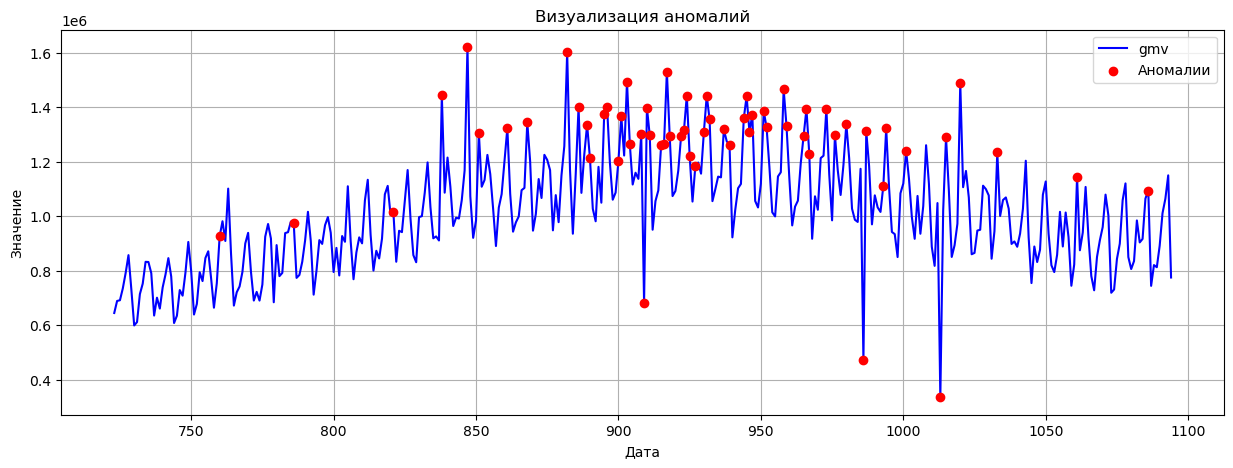

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(gmv_full.index, gmv_full, label='gmv', color='blue')

# Отмечаем аномалии
plt.scatter(gmv_full.loc[anomalys.index].index,
            gmv_full.loc[anomalys.index],
            color='red', label='Аномалии', zorder=5)

plt.title('Визуализация аномалий')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()


Как мож